In [1]:
import functools
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import scipy
from sklearn.model_selection import train_test_split
import time
import tqdm
from anndata import AnnData
import scanpy as sc

In [2]:
# Spatial LDA imports
# Spatial LDA imports
import spatial_lda.model

from featurization import featurize_tumors
from featurization import neighborhood_to_marker
from featurization import make_merged_difference_matrices

from visualization import plot_samples_in_a_row
from visualization import plot_one_tumor_all_topics
from visualization import plot_one_tumor_topic
from visualization import plot_topics_heatmap
from visualization import plot_adjacency_graph

c:\Users\40868\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set data path
data_path = "D:/Desktop/MGI/CODE/"

In [14]:
# Parameters
TRAIN_SIZE_FRACTION = 0.9
N_PARALLEL_PROCESSES = 8
TRAIN_SIZE_FRACTION = 0.9 
N_TOPICS = 5 
DIFFERENCE_PENALTY = 250 
RETRAIN_MODEL = True

In [ ]:
with open(data_path + "Data/patient_dfs.pkl", 'rb') as f:
   patient_dfs = pickle.load(f)
patient_dfs[1]

In [ ]:
for patient_id in patient_dfs.keys():
  df = patient_dfs[patient_id]
  df['combined_cluster_id'] = (df['immune_cluster'].fillna(0) + 
                               (df.cluster_id + 12).fillna(0))
  df.loc[df['combined_cluster_id'] == 0, 'combined_cluster_id'] = None
  df.loc[:, 'is_tumor'] = ~df['isimmune']
  patient_dfs[patient_id] = df

type(patient_dfs)

In [ ]:
with open(data_path + "Data/tumor_marker_features.pkl", 'rb') as f:
    tumor_marker_features = pickle.load(f)
tumor_marker_features

In [ ]:
tumor_marker_features.loc[[index for index in tumor_marker_features.index if index[0] == 41]]

In [4]:
data = sc.read_h5ad(data_path + "Data/SS200000116BR_E6.bin200.h5ad")

# annotation data
anno_data = pd.read_csv(data_path + "Output/RCTD_results.csv", index_col=0)
anno_data.index = anno_data.index.rename('ID')
anno_data.reset_index(inplace=True)
anno_data.drop(['x', 'y'], axis=1, inplace=True)
anno_data

,ID,spot_class,first_type,second_type,first_prob,second_prob,final_type
0,27487790701800,doublet_certain,Hepatocyte,Tumor-Cholang,0.363940,0.636060,Tumor-Cholang
1,29205777624400,doublet_certain,Tumor-Cholang,Hepatocyte,0.635929,0.364071,Tumor-Cholang
2,31782757998200,doublet_certain,Tumor-Cholang,Hepatocyte,0.638376,0.361624,Tumor-Cholang
3,32641751459800,doublet_certain,Tumor-Cholang,Hepatocyte,0.723940,0.276060,Tumor-Cholang
4,39513699138800,doublet_certain,Tumor-Cholang,Hepatocyte,0.862991,0.137009,Tumor-Cholang
...,...,...,...,...,...,...,...
10184,6012954233600,singlet,Hepatocyte,Endothelial,0.544437,0.455563,Hepatocyte
10185,2576980383000,singlet,Hepatocyte,Tumor-Cholang,0.536803,0.463197,Hepatocyte
10186,17179869208000,singlet,Hepatocyte,Tumor-Cholang,0.397441,0.602559,Tumor-Cholang
10187,11166914969600,doublet_certain,Hepatocyte,Tumor-Cholang,0.370117,0.629883,Tumor-Cholang


In [5]:
data_obs = data.obs.copy()
data_obs.index = data_obs.index.rename('ID')
data_obs.reset_index(inplace=True)

data_obs['ID'] = data_obs['ID'].astype(str)
anno_data['ID'] = anno_data['ID'].astype(str)

merged_data = pd.merge(data_obs, anno_data, on='ID', how='inner')
merged_data

,ID,orig.ident,x,y,spot_class,first_type,second_type,first_prob,second_prob,final_type
0,27487790701800,sample,6400,7400,doublet_certain,Hepatocyte,Tumor-Cholang,0.363940,0.636060,Tumor-Cholang
1,29205777624400,sample,6800,11600,doublet_certain,Tumor-Cholang,Hepatocyte,0.635929,0.364071,Tumor-Cholang
2,31782757998200,sample,7400,7800,doublet_certain,Tumor-Cholang,Hepatocyte,0.638376,0.361624,Tumor-Cholang
3,32641751459800,sample,7600,10200,doublet_certain,Tumor-Cholang,Hepatocyte,0.723940,0.276060,Tumor-Cholang
4,39513699138800,sample,9200,15600,doublet_certain,Tumor-Cholang,Hepatocyte,0.862991,0.137009,Tumor-Cholang
...,...,...,...,...,...,...,...,...,...,...
10184,6012954233600,sample,1400,19200,singlet,Hepatocyte,Endothelial,0.544437,0.455563,Hepatocyte
10185,2576980383000,sample,600,5400,singlet,Hepatocyte,Tumor-Cholang,0.536803,0.463197,Hepatocyte
10186,17179869208000,sample,4000,24000,singlet,Hepatocyte,Tumor-Cholang,0.397441,0.602559,Tumor-Cholang
10187,11166914969600,sample,2600,0,doublet_certain,Hepatocyte,Tumor-Cholang,0.370117,0.629883,Tumor-Cholang


In [6]:
merged_data['final_type'].unique()

array(['Tumor-Cholang', 'Hepatocyte', 'Endothelial', 'Fibroblast',
       'B cell', 'T-NK', 'Macrophage', 'Cycling'], dtype=object)

In [7]:
merged_data['is_tumor'] = np.where(merged_data['final_type'] == 'Tumor-Cholang', True, False)

immune_cell_types = {'B cell': True, 'T-NK': True, 'Macrophage': True}
merged_data['is_immune'] = np.where(merged_data['final_type'].isin(immune_cell_types.keys()), True, False)
merged_data

,ID,orig.ident,x,y,spot_class,first_type,second_type,first_prob,second_prob,final_type,is_tumor,is_immune
0,27487790701800,sample,6400,7400,doublet_certain,Hepatocyte,Tumor-Cholang,0.363940,0.636060,Tumor-Cholang,True,False
1,29205777624400,sample,6800,11600,doublet_certain,Tumor-Cholang,Hepatocyte,0.635929,0.364071,Tumor-Cholang,True,False
2,31782757998200,sample,7400,7800,doublet_certain,Tumor-Cholang,Hepatocyte,0.638376,0.361624,Tumor-Cholang,True,False
3,32641751459800,sample,7600,10200,doublet_certain,Tumor-Cholang,Hepatocyte,0.723940,0.276060,Tumor-Cholang,True,False
4,39513699138800,sample,9200,15600,doublet_certain,Tumor-Cholang,Hepatocyte,0.862991,0.137009,Tumor-Cholang,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
10184,6012954233600,sample,1400,19200,singlet,Hepatocyte,Endothelial,0.544437,0.455563,Hepatocyte,False,False
10185,2576980383000,sample,600,5400,singlet,Hepatocyte,Tumor-Cholang,0.536803,0.463197,Hepatocyte,False,False
10186,17179869208000,sample,4000,24000,singlet,Hepatocyte,Tumor-Cholang,0.397441,0.602559,Tumor-Cholang,True,False
10187,11166914969600,sample,2600,0,doublet_certain,Hepatocyte,Tumor-Cholang,0.370117,0.629883,Tumor-Cholang,True,False


In [8]:
print("tumor:", merged_data['is_tumor'].sum())
print("immune:", merged_data['is_immune'].sum())

tumor: 3832
immune: 58


In [20]:
# tumor data
tumor_data = merged_data[merged_data['is_tumor'] == True]
tumor_data = tumor_data[(tumor_data['x'] > 5900) & (tumor_data['y'] > 5500) & (tumor_data['y'] < 25700)]
tumor_data

,ID,orig.ident,x,y,spot_class,first_type,second_type,first_prob,second_prob,final_type,is_tumor,is_immune
0,27487790701800,sample,6400,7400,doublet_certain,Hepatocyte,Tumor-Cholang,0.363940,0.636060,Tumor-Cholang,True,False
1,29205777624400,sample,6800,11600,doublet_certain,Tumor-Cholang,Hepatocyte,0.635929,0.364071,Tumor-Cholang,True,False
2,31782757998200,sample,7400,7800,doublet_certain,Tumor-Cholang,Hepatocyte,0.638376,0.361624,Tumor-Cholang,True,False
3,32641751459800,sample,7600,10200,doublet_certain,Tumor-Cholang,Hepatocyte,0.723940,0.276060,Tumor-Cholang,True,False
4,39513699138800,sample,9200,15600,doublet_certain,Tumor-Cholang,Hepatocyte,0.862991,0.137009,Tumor-Cholang,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
10146,25769803783000,sample,6000,7000,doublet_uncertain,Hepatocyte,Tumor-Cholang,0.474411,0.525589,Tumor-Cholang,True,False
10153,26628797241200,sample,6200,6000,doublet_certain,Hepatocyte,Tumor-Cholang,0.388007,0.611993,Tumor-Cholang,True,False
10160,29205777638400,sample,6800,25600,doublet_uncertain,Hepatocyte,Tumor-Cholang,0.496753,0.503247,Tumor-Cholang,True,False
10170,110810156261200,sample,25800,24400,singlet,Hepatocyte,Tumor-Cholang,0.427688,0.572312,Tumor-Cholang,True,False


In [21]:
# Dataframe to Anndata
tumor_data_ann = AnnData(obs=tumor_data, var=data.var)
aligned_X = data[data.obs.index.isin(tumor_data_ann.obs["ID"])].X
tumor_data_ann = AnnData(X=aligned_X.toarray(), obs=tumor_data, var=data.var)

c:\Users\40868\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
c:\Users\40868\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [22]:
features = pd.DataFrame(tumor_data_ann.X.astype(int), columns=tumor_data_ann.var.index)
features.index = [(1, idx) for idx in features.index]
features

,AL354822.1,AC233755.2,AC007325.2,AC011841.1,MAFIP,BX004987.1,AC136616.1,AC136612.1,TTTY3B,DAZ2,...,AEBP1,KLHL8,AC237221.1,AC006455.1,SELENOI,HABP2,SEC61G,HSP90B1,IGFBP1,SERPINA1
"(1, 0)",3,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,1,2,5,5,66
"(1, 1)",2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,4,12,110
"(1, 2)",1,0,0,0,0,0,0,0,0,0,...,3,0,0,0,1,6,5,24,14,167
"(1, 3)",1,0,0,0,0,0,0,0,0,0,...,3,0,0,0,1,4,2,10,9,99
"(1, 4)",1,0,0,0,0,0,0,0,0,0,...,17,1,0,0,6,25,56,148,44,781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(1, 3769)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,4
"(1, 3770)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
"(1, 3771)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,8
"(1, 3772)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [23]:
patient = tumor_data_ann.obs
patient.reset_index(drop=True, inplace=True)

patient_dict = dict()

patient_dict[1] = patient
patient_dict

{1:                    ID orig.ident      x      y         spot_class  \
 0      27487790701800     sample   6400   7400    doublet_certain   
 1      29205777624400     sample   6800  11600    doublet_certain   
 2      31782757998200     sample   7400   7800    doublet_certain   
 3      32641751459800     sample   7600  10200    doublet_certain   
 4      39513699138800     sample   9200  15600    doublet_certain   
 ...               ...        ...    ...    ...                ...   
 3769   25769803783000     sample   6000   7000  doublet_uncertain   
 3770   26628797241200     sample   6200   6000    doublet_certain   
 3771   29205777638400     sample   6800  25600  doublet_uncertain   
 3772  110810156261200     sample  25800  24400            singlet   
 3773   30064771077800     sample   7000   5800            singlet   
 
          first_type    second_type  first_prob  second_prob     final_type  \
 0        Hepatocyte  Tumor-Cholang    0.363940     0.636060  Tumor-Cholang 

In [24]:
_sets = train_test_split(features, test_size=1. - TRAIN_SIZE_FRACTION)
train_features, test_features = _sets

In [25]:
train_difference_matrices = make_merged_difference_matrices(train_features, patient_dict, 'x', 'y')

In [30]:
spatial_lda_model = spatial_lda.model.train(train_features, 
                                            train_difference_matrices, 
                                            n_topics=N_TOPICS, 
                                            difference_penalty=DIFFERENCE_PENALTY, 
                                            verbosity=1,
                                            n_parallel_processes=N_PARALLEL_PROCESSES,
                                            n_iters=3,
                                            admm_rho=0.1,
                                            primal_dual_mu=2)

LDA training: 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]


In [31]:
with open(data_path + "Model/spatial_lda_1.pkl", 'wb') as f:
    pickle.dump(spatial_lda_model, f)

In [33]:
with open(data_path + "Model/spatial_lda_1.pkl", 'rb') as f:
    complete_lda = pickle.load(f)

In [34]:
x_min = patient_dict[1]['x'].min()
x_max = patient_dict[1]['x'].max()
y_min = patient_dict[1]['y'].min()
y_max = patient_dict[1]['y'].max()

print("Range of x:", x_min, "-", x_max)
print("Range of y:", y_min, "-", y_max)

Range of x: 6000 - 25800
Range of y: 5600 - 25600


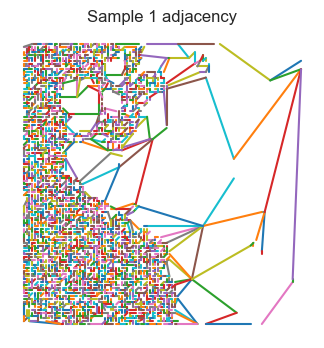

In [35]:
def make_plot_fn(difference_matrices):  
    def plot_fn(ax, tumor_idx, features_df, patient_dfs):
        plot_adjacency_graph(ax, tumor_idx, features_df, patient_dfs, difference_matrices)
    return plot_fn
_plot_fn = make_plot_fn(train_difference_matrices)

plot_samples_in_a_row(train_features, _plot_fn, patient_dict, tumor_set=None)

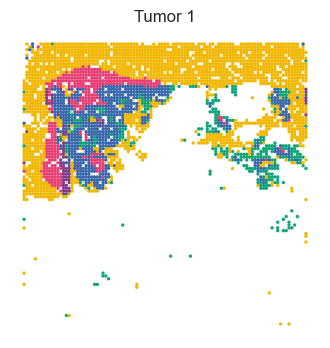

In [36]:
plot_samples_in_a_row(complete_lda.topic_weights, plot_one_tumor_all_topics, patient_dict)
